In [1]:
import tensorflow
from keras.layers import Conv2D,MaxPooling2D, AveragePooling2D,ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
datagen = ImageDataGenerator(rescale = 1./255)
train_data = datagen.flow_from_directory("dataset/Train/", target_size = (224,224), batch_size = 15, class_mode = 'categorical')
test_data = datagen.flow_from_directory("dataset/valid/", target_size = (224,224), batch_size = 15, class_mode = 'categorical')

Found 8512 images belonging to 7 classes.
Found 1503 images belonging to 7 classes.


In [3]:
from sklearn.model_selection import train_test_split
x_train,y_train=train_test_split(train_data,test_size=0.3,random_state=42)

In [4]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
k_size = 3

In [6]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [7]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [8]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [9]:
def ResUNet50(shape = (224, 224, 3), classes = 7):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResUNet50")
    return model
# model.summary()

In [10]:
use_multiprocessing=True

In [11]:
model = ResUNet50(shape=(224, 224, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',precision,recall,sensitivity,specificity])
hist=model.fit(train_data, epochs=25,validation_data=test_data)

Epoch 1/25
568/568 [==============================] - 2386s 4s/step - loss: 1.8892 - accuracy: 0.6449 - precision: 0.7408 - recall: 0.5257 - sensitivity_at_specificity: 0.9744 - specificity_at_sensitivity: 0.9979 - val_loss: 0.9749 - val_accuracy: 0.6693 - val_precision: 0.7701 - val_recall: 0.5862 - val_sensitivity_at_specificity: 0.9874 - val_specificity_at_sensitivity: 0.9998
Epoch 2/25
568/568 [==============================] - 2307s 4s/step - loss: 0.9452 - accuracy: 0.6793 - precision: 0.7902 - recall: 0.5663 - sensitivity_at_specificity: 0.9913 - specificity_at_sensitivity: 0.9996 - val_loss: 0.9050 - val_accuracy: 0.6860 - val_precision: 0.8759 - val_recall: 0.4930 - val_sensitivity_at_specificity: 0.9980 - val_specificity_at_sensitivity: 0.9997
Epoch 3/25
568/568 [==============================] - 2339s 4s/step - loss: 0.9111 - accuracy: 0.6884 - precision: 0.7990 - recall: 0.5871 - sensitivity_at_specificity: 0.9911 - specificity_at_sensitivity: 0.9995 - val_loss: 1.4975 - va

568/568 [==============================] - 2317s 4s/step - loss: 0.3952 - accuracy: 0.8508 - precision: 0.8819 - recall: 0.8234 - sensitivity_at_specificity: 0.9980 - specificity_at_sensitivity: 1.0000 - val_loss: 0.8536 - val_accuracy: 0.7585 - val_precision: 0.7880 - val_recall: 0.7345 - val_sensitivity_at_specificity: 0.9667 - val_specificity_at_sensitivity: 0.9987
Epoch 23/25
568/568 [==============================] - 2337s 4s/step - loss: 0.3513 - accuracy: 0.8685 - precision: 0.8935 - recall: 0.8435 - sensitivity_at_specificity: 0.9984 - specificity_at_sensitivity: 0.9999 - val_loss: 1.0417 - val_accuracy: 0.7399 - val_precision: 0.7560 - val_recall: 0.7279 - val_sensitivity_at_specificity: 0.9415 - val_specificity_at_sensitivity: 0.9963
Epoch 24/25
568/568 [==============================] - 2271s 4s/step - loss: 0.3079 - accuracy: 0.8864 - precision: 0.9069 - recall: 0.8685 - sensitivity_at_specificity: 0.9982 - specificity_at_sensitivity: 0.9998 - val_loss: 0.9420 - val_accurac

In [12]:
model.save("NEW models/resUnet.h5")

In [15]:
STEP_SIZE_VALID=test_data.n//test_data.batch_size

In [16]:
model.evaluate(test_data, verbose=1, steps=STEP_SIZE_VALID)

100/100 [==============================] - 122s 1s/step - loss: 1.0341 - accuracy: 0.7540 - precision: 0.7697 - recall: 0.7353 - sensitivity_at_specificity: 0.9447 - specificity_at_sensitivity: 0.9970


[1.0341436862945557,
 0.7540000081062317,
 0.7697138786315918,
 0.7353333234786987,
 0.9446666836738586,
 0.996999979019165]

In [17]:
filenames = test_data.filenames 
nb_samples = len(filenames)
model_predict = model.predict(test_data,steps = nb_samples, verbose=2)


1503/1503 - 130s - 130s/epoch - 86ms/step


Confusion matrix, without normalization
[[  1   3   3   0   5  36   1]
 [  2   5  10   0   8  52   0]
 [  3   4  12   2  17 124   3]
 [  1   1   1   0   1  13   0]
 [  4   5   7   0  14 136   1]
 [ 34  44  82   7 100 723  16]
 [  1   1   5   0   1  14   0]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

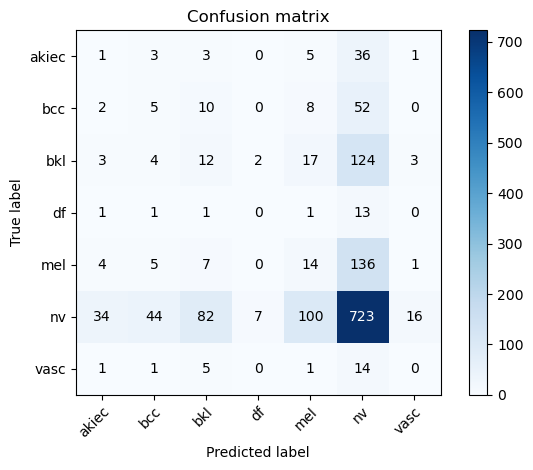

In [18]:
y_true = test_data.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['akiec','bcc','bkl','df','mel','nv','vasc'],
                      title='Confusion matrix')

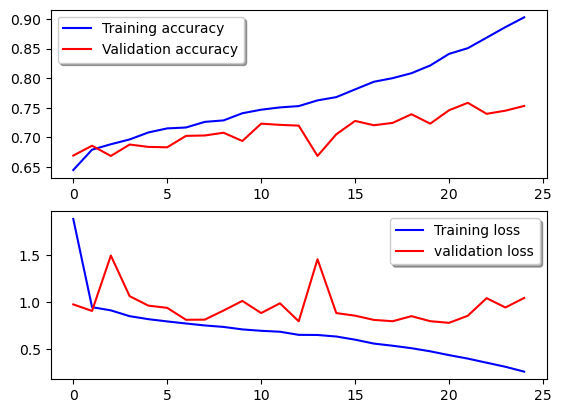

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)